In [ ]:
! pip install -qU transformers datasets optimum google-generativeai wandb json-repair evaluate accelerate pyarabic nltk farasapy
!huggingface-cli login --token "YOUR_HF_TOKEN"

In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset
import torch
import torch.nn as nn

from Model import BertForSentimentClassification
from Trainer import Trainer
from TrainingArgs import TrainerArgs

In [6]:
ds = load_dataset("Qanadil/ArSAS_An_Arabic_Speech-Act_and_Sentiment_Corpus_of_Tweets")
split_ds = ds['train'].train_test_split(test_size=0.3, seed=42)

train_ds = split_ds['train']
val_ds = split_ds['test']

model_name = "asafaya/bert-base-arabic"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSentimentClassification(model_name, num_labels=3, dropout_prob=0.3)

def tokenize(example):
    return tokenizer(example["Tweet_text"], truncation=True, padding="max_length", max_length=512)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

README.md:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18678 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

2025-05-03 17:38:05.753010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746293885.932269      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746293885.987195      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Map:   0%|          | 0/13074 [00:00<?, ? examples/s]

Map:   0%|          | 0/5604 [00:00<?, ? examples/s]

In [7]:
# ds = load_dataset("Qanadil/ArSAS_An_Arabic_Speech-Act_and_Sentiment_Corpus_of_Tweets")
# small_ds = ds['train'].train_test_split(test_size=0.01, seed=42)['test']
# split_ds = small_ds.train_test_split(test_size=0.3, seed=42)
# train_ds = split_ds['train'].shuffle(seed=21)
# val_ds = split_ds['test'].shuffle(seed=12)

# model_name = "asafaya/bert-base-arabic"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = BertForSentimentClassification(model_name, num_labels=3, dropout_prob=0.3)

# def tokenize(example):
#     return tokenizer(example["Tweet_text"], truncation=True, padding="max_length", max_length=512)

# train_ds = train_ds.map(tokenize, batched=True)
# val_ds = val_ds.map(tokenize, batched=True)

In [8]:
def fix_labels(example):
    label_mapping = {"Positive": 0, "Neutral": 1, "Negative": 2}
    example["Sentiment_label"] = label_mapping[example["Sentiment_label"]]
    return example

# Apply the label fix
train_ds = train_ds.map(fix_labels)
val_ds = val_ds.map(fix_labels)

train_ds = train_ds.rename_column("Sentiment_label", "labels")
val_ds = val_ds.rename_column("Sentiment_label", "labels")

train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/13074 [00:00<?, ? examples/s]

Map:   0%|          | 0/5604 [00:00<?, ? examples/s]

In [9]:
# import torch
# import gc # Python's garbage collector

# def clear_cuda_cache():
#     print("Attempting to clear CUDA cache...")

#     # Check if CUDA is available and initialized
#     if torch.cuda.is_available():
#         # Primary function to empty the CUDA cache
#         torch.cuda.empty_cache()
#         print("torch.cuda.empty_cache() called.")

#         # Optional: Explicitly run Python's garbage collector
#         # This can sometimes help ensure Python releases references to objects
#         # (like tensors) that are no longer reachable, allowing PyTorch's
#         # cache clearer to potentially free more memory.
#         gc.collect()
#         print("Garbage collector run.")

#         # You can add memory reporting here if needed
#         # print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
#         # print(f"CUDA Memory Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB") # Use memory_reserved for cache

#     else:
#         print("CUDA is not available. No cache to clear.")

# clear_cuda_cache()

In [10]:
train_ds.num_rows, val_ds.num_rows

(13074, 5604)

In [11]:
args = TrainerArgs(
    num_train_epochs=7,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    weight_decay=0.05,
    loss_fn=nn.CrossEntropyLoss(),
    scheduler_type="linear",
    gradient_accumulation=4,
    early_stopping_patience=1,
    early_stopping_metric="val_loss",
)

trainer = Trainer(model, args, train_ds, val_ds, tokenizer)

In [12]:
trainer.train()

=============== Epoch 1 ===============


Epoch 1 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]

Train Loss: 1.001946099667211, Train Accuracy: 0.5126969557901178


Epoch 1 [Eval]:   0%|          | 0/701 [00:00<?, ?it/s]

Val Loss: 0.6556894103870242, Val Accuracy: 0.7323340471092077
[EarlyStopping] val_loss: 0.6557, Best: 0.6557, Epochs without improvement: 0
=============== Epoch 2 ===============


Epoch 2 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]

Train Loss: 0.5343839244919384, Train Accuracy: 0.6480419152516445


Epoch 2 [Eval]:   0%|          | 0/701 [00:00<?, ?it/s]

Val Loss: 0.509340388931536, Val Accuracy: 0.7928265524625268
[EarlyStopping] val_loss: 0.5093, Best: 0.5093, Epochs without improvement: 0
=============== Epoch 3 ===============


Epoch 3 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]

Train Loss: 0.4124764602533419, Train Accuracy: 0.7105451022385396


Epoch 3 [Eval]:   0%|          | 0/701 [00:00<?, ?it/s]

Val Loss: 0.451177274773745, Val Accuracy: 0.816916488222698
[EarlyStopping] val_loss: 0.4512, Best: 0.4512, Epochs without improvement: 0
=============== Epoch 4 ===============


Epoch 4 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]

Train Loss: 0.3027754874571965, Train Accuracy: 0.753365458161236


Epoch 4 [Eval]:   0%|          | 0/701 [00:00<?, ?it/s]

Val Loss: 0.4700296973376488, Val Accuracy: 0.8110278372591007
[EarlyStopping] val_loss: 0.4700, Best: 0.4512, Epochs without improvement: 1
Early stopping triggered! No improvement in 1 consecutive epochs.


{'train_loss': [1.001946099667211,
  0.5343839244919384,
  0.4124764602533419,
  0.3027754874571965],
 'train_accuracy': [0.5126969557901178,
  0.6480419152516445,
  0.7105451022385396,
  0.753365458161236],
 'val_loss': [0.6556894103870242,
  0.509340388931536,
  0.451177274773745,
  0.4700296973376488],
 'val_accuracy': [0.7323340471092077,
  0.7928265524625268,
  0.816916488222698,
  0.8110278372591007]}

In [13]:
trainer.save_model("./Arabic-Sentiment-CLF", "ar_bert_model.bin")

'PyTorch model state_dict saved to ./Arabic-Sentiment-CLF/ar_bert_model.bin'

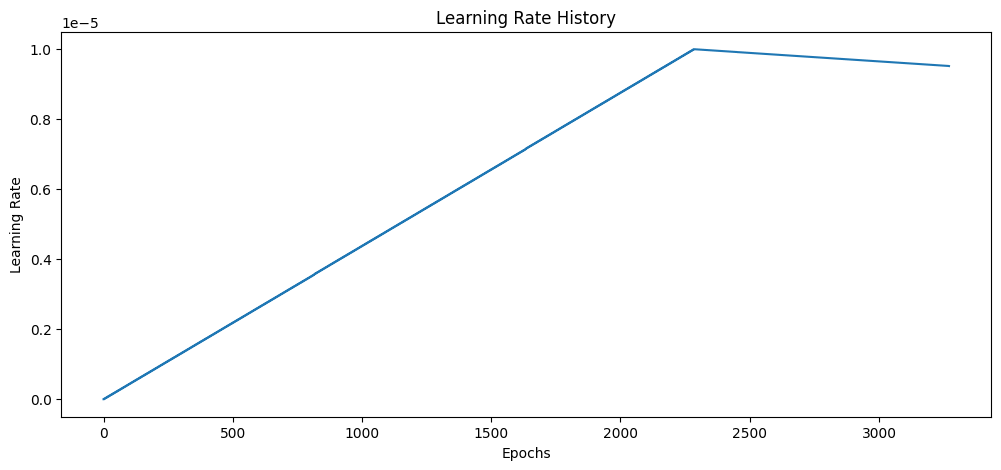

In [14]:
trainer.plot_lr_history()

ValueError: x and y must have same first dimension, but have shapes (7,) and (4,)

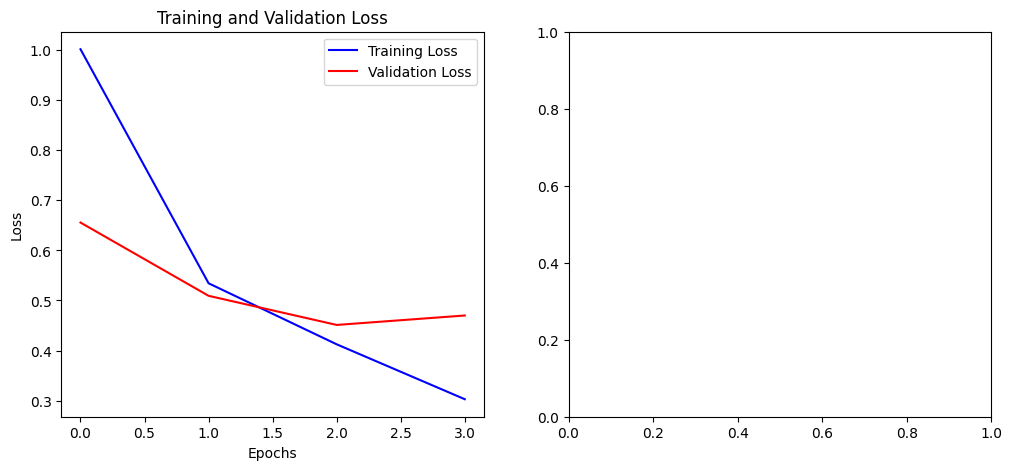

In [15]:
trainer.plot_history()